<a href="https://colab.research.google.com/github/Niron-code/FAW-deaplearning-model/blob/main/classification_corn_leaf_infection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Corn Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    break

/content/drive/MyDrive/Corn Dataset/Annotation-export.csv


In [13]:
root_dir = "/content/drive/MyDrive/Corn Dataset/Corn Disease detection"
os.listdir(root_dir)

['Healthy corn', 'Infected']

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [15]:
# hyper parameters
batch_size = 32
img_height, img_width=128,128
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    root_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    root_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 3380 images belonging to 2 classes.
Found 845 images belonging to 2 classes.


In [16]:
validation_generator[0][1][1]

array([1., 0.], dtype=float32)

In [17]:
def show(img, title=None, fig_size=(5, 5)):
    fig = plt.figure(figsize=fig_size)
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

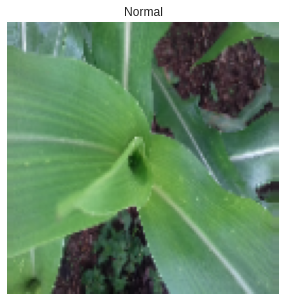

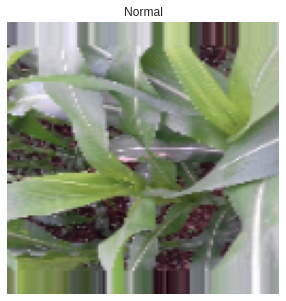

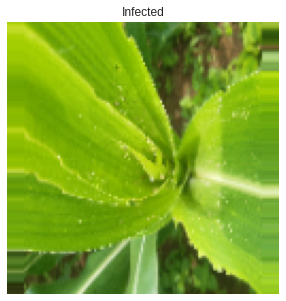

In [18]:
import cv2
plt.style.use('seaborn-whitegrid')
for i in range(3):
    labels = ["Normal", "Infected"]
    img = validation_generator[0][0][i]
    lbl = labels[np.argmax(validation_generator[0][1][i])]
    
    img = cv2.resize(img, (img_height, img_width))
    img = img.reshape(img_height, img_width, 3)
    show(img, title=lbl)

In [19]:
from keras.applications.inception_resnet_v2 import preprocess_input, InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from keras.models import Model

img_input = Input(shape=(img_height, img_width, 3), name = 'grayscale_input_layer')
# x = Conv2D(3, (3,3),  padding= 'same', name = 'grayscale_RGB_layer')(img_input)
inception = InceptionResNetV2(input_shape = (img_height, img_width, 3), include_top = False, weights = 'imagenet')
inception.layers.pop()  # Remove classification layer

for layer in inception.layers:
    layer.trainable = False
    if type(layer) == 'BatchNormalization':
        layer.momentum = 1.0

inception = inception(img_input)
output = inception
output = GlobalAveragePooling2D()(output)

output = Dropout(0.5)(output)
output = Dense(2, activation="softmax")(output) 
model = Model(inputs=[img_input], outputs=[output], name='embedding_model')

In [20]:
lr=1e-03
epochs=15

opt = Adam(lr=lr, decay=lr / epochs)

# compile
model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])

# train
history=model.fit_generator(
	train_generator,
	steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
	epochs=epochs,
  verbose=1,
	workers=32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
106/106 [==============================] - 928s 8s/step - loss: 0.9874 - accuracy: 0.6458 - val_loss: 0.6917 - val_accuracy: 0.7112
Epoch 2/15
106/106 [==============================] - 776s 7s/step - loss: 0.3889 - accuracy: 0.8475 - val_loss: 0.4549 - val_accuracy: 0.7905
Epoch 3/15
106/106 [==============================] - 793s 8s/step - loss: 0.3094 - accuracy: 0.8779 - val_loss: 0.3798 - val_accuracy: 0.8402
Epoch 4/15
106/106 [==============================] - 784s 7s/step - loss: 0.2747 - accuracy: 0.8997 - val_loss: 0.4312 - val_accuracy: 0.8213
Epoch 5/15
106/106 [==============================] - 807s 8s/step - loss: 0.2431 - accuracy: 0.9101 - val_loss: 0.3959 - val_accuracy: 0.8237
Epoch 6/15
106/106 [==============================] - 781s 7s/step - loss: 0.2583 - accuracy: 0.9075 - val_loss: 0.3924 - val_accuracy: 0.8402
Epoch 7/15
106/106 [==============================] - 792s 8s/step - loss: 0.2611 - accuracy: 0.9037 - val_loss: 0.4464 - val_accuracy: 0.8201

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


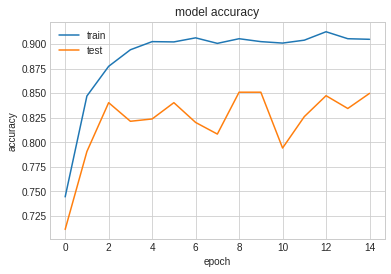

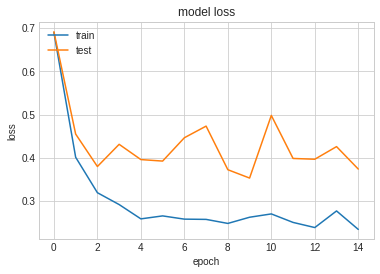

In [21]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
#save architecture as json and weight as h5
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


In [ ]:
# Convert the h5 file to tflite file

import traceback

from os.path import splitext, basename

mod_path = "/content/model.h5"

def load_model(path,custom_objects={},verbose=0):
    #from tf.keras.models import model_from_json

    path = splitext(path)[0]
    with open('%s.json' % path,'r') as json_file:
        model_json = json_file.read()
    model = tf.keras.models.model_from_json(model_json, custom_objects=custom_objects)
    model.load_weights('%s.h5' % path)
    if verbose: print('Loaded from %s' % path)
    return model

keras_mod = load_model(mod_path)

converter = tf.lite.TFLiteConverter.from_keras_model(keras_mod)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)